In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot(OFF, bin_centers,hist, bins, m=False, func=False, title=''):
    idx = OFF > 0
    fig = plt.figure(figsize=(15, 6))
    fig.tight_layout()
    plt.errorbar(bin_centers, hist,np.sqrt(hist+1), alpha=0.5, label='Data', fmt='ko', color='blue')
    plt.hist(OFF[idx],bins,histtype='bar',color='lightblue',density=False,alpha=0.5)
    plt.xlabel('[A.U.]')
    plt.ylabel('Counts')
    plt.title(title)
    plt.grid(True)

    if m and func:
        plt.errorbar(bin_centers, func(bin_centers,*m.values),np.sqrt(func(bin_centers,*m.values)), fmt='ko',color='black',linestyle='-', label='MIGRAD',alpha=0.8)

        title = []
        for par in m.parameters:
            title.append(
                f"{par} = {m.values[par]:.5f} +/- {m.errors[par]:.5f}"
            )
        title.append(r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}")

        # Create the legend
        legend = plt.legend(title="\n".join(title),fontsize=10)

        # Adjust the title's font size
        legend.get_title().set_fontsize(10)  # or use a numeric value like 8

In [3]:
OFF = np.genfromtxt('/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS/OPTIMUM/TXT/maxs.txt')

In [4]:
bins = 20  # Number of bins
hist, bin_edges = np.histogram(OFF, bins=bins, density=False)
# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

/tmp/ipykernel_16047/2832061085.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(bin_centers, hist,np.sqrt(hist+1), alpha=0.5, label='Data', fmt='ko', color='blue')


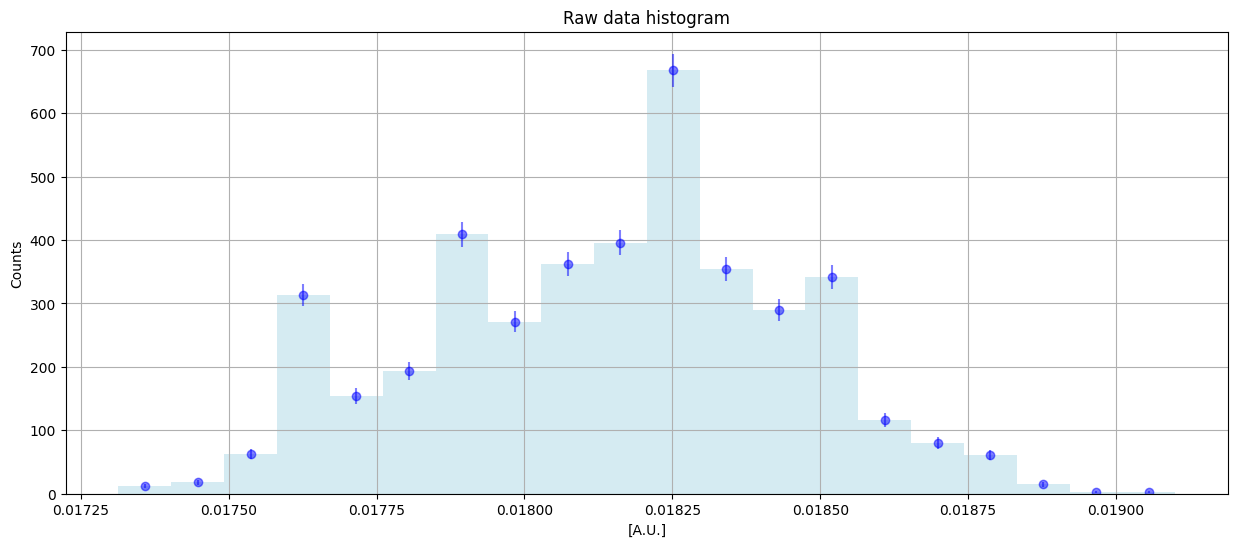

In [5]:
plot(OFF,bin_centers,hist,bins,title='Raw data histogram')

In [6]:
from scipy.stats import poisson, norm

def compute_sum_poisson_gaussian(amplitudes, A, mu, delta, sigma, Egamma):
    """
    Compute the sum over n of P(n; µ)·G(OFF; nEγ + delta; σ)
    
    Parameters:
    - amplitudes: Array of measured amplitudes (OFF).
    - N: Maximum number of photons to consider.
    - mu: Mean of the Poisson distribution.
    - delta: Offset for the Gaussian distribution.
    - sigma: Standard deviation of the Gaussian distribution.
    - Egamma: Energy of a single photon.
    
    Returns:
    - Array of computed values for the given amplitudes.
    """
    # Initialize result array
    result = np.zeros_like(amplitudes)

    N = 200 
    
    # Array of possible photon numbers
    photon_numbers = np.arange(0, N+1, dtype=int)
    
    # Compute Poisson probabilities for all photon numbers
    poisson_probs = poisson.pmf(photon_numbers, mu)
    
    # Compute the Gaussian PDF for each photon number and sum up
    for i, n in enumerate(photon_numbers):
        # Compute Gaussian PDF for the current number of photons
        gaussian_values = norm.pdf(amplitudes, loc=n * Egamma + delta, scale=sigma)
        
        # Update result array
        result += poisson_probs[i] * gaussian_values
    
    return A * result

In [231]:
A = 2
mu = 4
delta = 0.015
sigma = 0.0004 
Egamma = 0.0008
p0 = [A, mu, delta, sigma, Egamma]

In [232]:
model_values = compute_sum_poisson_gaussian(bin_centers, A, mu, delta, sigma, Egamma)

In [233]:
from iminuit.cost import LeastSquares
from iminuit import minuit

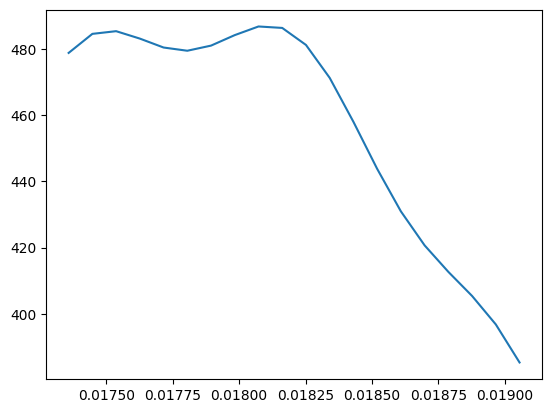

In [235]:
plt.plot(bin_centers,model_values)

In [236]:
lsq = LeastSquares(bin_centers,hist,np.sqrt(hist+1),compute_sum_poisson_gaussian)
m = minuit.Minuit(lsq, *p0)
#m.fixed['Egamma'] = True
#m.fixed['sigma'] = True
m.migrad(ncall=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 454.1 (χ²/ndof = 30.3)     │             Nfcn = 1147              │
│ EDM = 2.65e-06 (Goal: 0.0002)    │           time = 26.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │   0.329   │   0.005   │            │            │         │         │       │
│ 1 │ mu     │   5.98    │   0.04    │            │            │         │         │       │
│ 2 │ delta  │17.3939e-3 │ 0.0032e-3 │            │            │         │         │       │
│ 3 │ sigma  │  39.6e-6  │  0.9e-6   │            │            │         │         │       │
│ 4 │ Egamma │ 124.7e-6  │  0.5e-6   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────┐
│        │           A          mu       delta       sigma      Egamma │
├────────┼─────────────────────────────────────────────────────────────┤
│      A │    2.97e-05    0.003e-3   -0.081e-9     3.6e-12   11.38e-12 │
│     mu │    0.003e-3     0.00161    5.338e-9  -945.1e-12 -3.30617e-9 │
│  delta │   -0.081e-9    5.338e-9    1.03e-11     0.2e-12   -1.37e-12 │
│  sigma │     3.6e-12  -945.1e-12     0.2e-12     7.7e-13   -0.02e-12 │
│ Egamma │   11.38e-12 -3.30617e-9   -1.37e-12   -0.02e-12    2.38e-13 │
└────────┴─────────────────────────────────────────────────────────────┘

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [25]:
with h5py.File('/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS/FINAL/RUN_2_PULSE_1(1).hdf5','r') as hdf5:
    I = hdf5['Signals']['I'][:]
    Q = hdf5['Signals']['Q'][:]

In [26]:
rms_i_signal = np.sqrt(np.sum(I[np.argmin(I)-1000:np.argmin(I)+19000]**2)/2e4)
rms_i_noise  = np.sqrt(np.sum(I[I.shape[0]-10000:]**2)/(10000))

print(f'RMS_I_signal : {rms_i_signal}')
print(f'RMS_I_noise  : {rms_i_noise}')

RMS_I_signal : 0.02614025920486173
RMS_I_noise  : 0.026042129449131018


In [27]:
rms_q_signal = np.sqrt(np.sum(Q[np.argmin(I)-1000:np.argmin(I)+19000]**2)/2e4)
rms_q_noise  = np.sqrt(np.sum(Q[I.shape[0]-10000:]**2)/(10000))

print(f'RMS_Q_signal : {rms_q_signal}')
print(f'RMS_Q_noise  : {rms_q_noise}')

RMS_Q_signal : 0.017140705918941877
RMS_Q_noise  : 0.01751381388889463


In [28]:
S21 = 20*np.log10(np.sqrt(I**2+Q**2))
P   = np.unwrap(np.angle(1j*I+Q)) 
ts = np.linspace(0,I[np.argmin(I)-1000:np.argmin(I)+19000].shape[0],I[np.argmin(I)-1000:np.argmin(I)+19000].shape[0])

In [29]:
rms_S21_signal = np.sqrt(np.sum(S21[np.argmin(I)-1000:np.argmin(I)+19000]**2)/2e4)
rms_S21_noise  = np.sqrt(np.sum(S21[I.shape[0]-10000:]**2)/(10000))

print(f'RMS_S21_signal : {rms_S21_signal}')
print(f'RMS_S21_noise  : {rms_S21_noise}')

RMS_S21_signal : 30.101181018063848
RMS_S21_noise  : 30.0665928270371


In [30]:
rms_P_signal = np.sqrt(np.sum(P[np.argmin(I)-1000:np.argmin(I)+19000]**2)/2e4)
rms_P_noise  = np.sqrt(np.sum(P[I.shape[0]-10000:]**2)/(10000))

print(f'RMS_P_signal : {rms_P_signal}')
print(f'RMS_P_noise  : {rms_P_noise}')

RMS_P_signal : 0.990700918930759
RMS_P_noise  : 0.9788483125253765


In [31]:
print(f'SNR(I  ) = {20*np.log10(rms_i_signal/rms_i_noise)}')
print(f'SNR(Q  ) = {20*np.log10(rms_q_signal/rms_q_noise)}')
print(f'SNR(S21) = {20*np.log10(rms_S21_signal/rms_S21_noise)}')
print(f'SNR(P  ) = {20*np.log10(rms_P_signal/rms_P_noise)}')

SNR(I  ) = 0.03266792706122673
SNR(Q  ) = -0.18704053022142034
SNR(S21) = 0.009986383870742766
SNR(P  ) = 0.10454338723043417


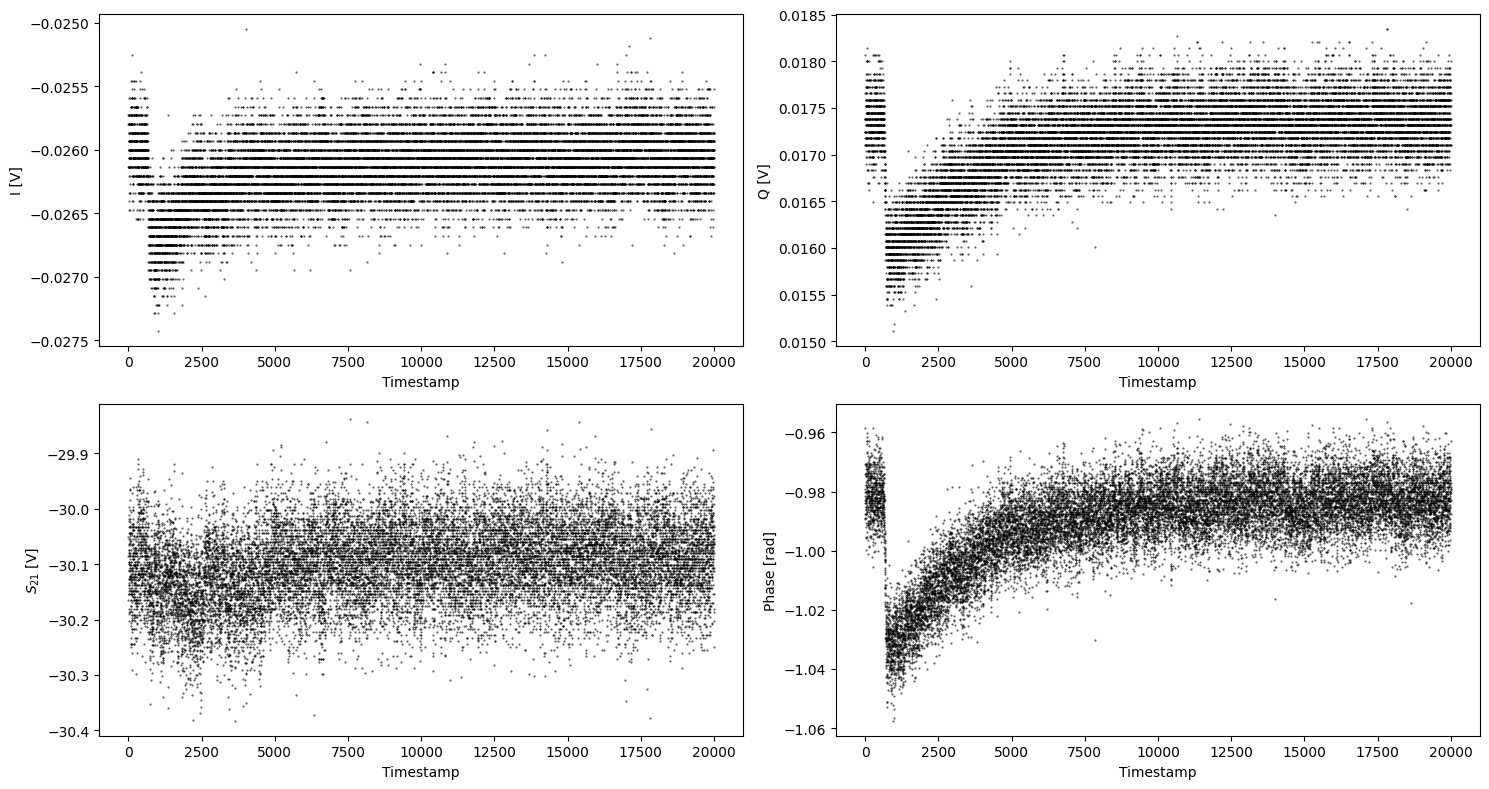

In [32]:
fig, axs = plt.subplots(2,2,figsize=(15,8))
axs[0][0].scatter(ts,I[np.argmin(I)-1000:np.argmin(I)+19000],marker='.',s=1,color='black',alpha=0.7,label='I Channel')
axs[0][0].set_xlabel('Timestamp')
axs[0][0].set_ylabel('I [V]')


axs[0][1].scatter(ts,Q[np.argmin(I)-1000:np.argmin(I)+19000],marker='.',s=1,color='black',alpha=0.7,label='Q Channel')
axs[0][1].set_xlabel('Timestamp')
axs[0][1].set_ylabel('Q [V]')

axs[1][0].scatter(ts,S21[np.argmin(I)-1000:np.argmin(I)+19000],marker='.',s=1,color='black',alpha=0.7,label='$S_{21}$')
axs[1][0].set_xlabel('Timestamp')
axs[1][0].set_ylabel('$S_{21}$ [V]')

axs[1][1].scatter(ts,P[np.argmin(I)-1000:np.argmin(I)+19000],marker='.',s=1,color='black',alpha=0.7,label='Phase')
axs[1][1].set_xlabel('Timestamp')
axs[1][1].set_ylabel('Phase [rad]')
fig.tight_layout()